In [1]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab
from scipy import stats 

from  qgrid import show_grid as show 
from datetime import datetime

today=!(date +"%d%m%y")
today=today[0]
testname="testweekend161118"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]
sensors.create_index([('timestamp',pymongo.ASCENDING)])

'timestamp_1'

In [4]:
def get_times(target,source=db["testcases"+testname]):
    """convert the time stamps from int to datetame """
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    """need a time object from get_times function and return 2 dataframes  """
    cursor =sensors.find({'target':'system','timestamp' :{'$gte':times['begin'],'$lte':times['end']}},{"_id":0,"timestamp":"timestamp","rapl.0.38.RAPL_ENERGY_PKG":"rapls"})
    results=pd.DataFrame(list(cursor),columns=['timestamp',"rapl"])
    results["rapl"]=results["rapl"].apply(lambda row :math.ldexp( row['0']['38']['RAPL_ENERGY_PKG'],-32))
    warmup=results[(results["timestamp"]<=times["execution"]) & (results["timestamp"]>times["warmup"] )]
    execution = results[(results["timestamp"]>times["execution"]) ]
    return warmup , execution

def calculate_energy(times,source=sensors) : 
    """need a times object from get_times """
    warmup,execution =calculate_power(times)
    return   warmup["rapl"].sum() , execution["rapl"].sum()

def get_recap(target):
    """require a row from the database and not a times object"""
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy[0] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy[1]
           }

In [5]:
regx = re.compile(".*float.*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
    
data=pd.DataFrame.from_dict(data)
show(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)float1', name).group(1))
mystats=data.groupby("implementation").median()
mystats=mystats.sort_values("execution time",ascending=False)
show(mystats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Text(0.5,0,'energy(j)')

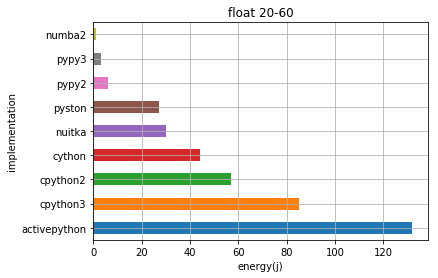

In [7]:
mystats['execution time'].plot(kind='barh',grid=True,title="float 20-60",sort_columns=True).set_xlabel("energy(j)")

In [10]:
regx = re.compile(".*cpython2float2n.*", re.IGNORECASE)
times1=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data1 = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data1=[]
times1.apply(lambda row: data1.append(get_recap(row)), axis=1)
    
data1=pd.DataFrame.from_dict(data1)
show(data1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
y=data1['execution energy']
low = 0
high = 1
a,b = y.quantile([low, high])
y=y[(y > a)  & (y  < b)  ]
print(stats.shapiro(y))
y.plot.kde()
# show(y)

KeyError: 'execution energy'